In [1]:
%matplotlib inline

In this notebook, I will try to fit the transit light curve using Gaussian Processes. 

In [2]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import lightkurve as lk
import aesara_theano_fallback.tensor as tt
# import theano.tensor as tt
from celerite2.theano import terms, GaussianProcess

# starry.config.quiet = True
# np.random.seed(1)

First, I need to download the data from the $\texttt{lightkurve}$.

In [3]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()

In [4]:
all_lc = lc_collection.stitch()
all_lc = all_lc.remove_nans().remove_outliers()
# Require non-zero quality flags
all_lc = all_lc[all_lc.quality == 0]

In [5]:
period = np.linspace(2, 20, 10000)
bls = all_lc.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_period = bls.period_at_max_power
planet_t0 = bls.transit_time_at_max_power
planet_dur = bls.duration_at_max_power*1.5

In [6]:
planet_t0

<Time object: scale='tdb' format='bkjd' value=124.85859840558085>

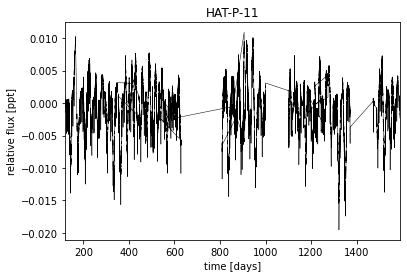

In [7]:
# Make sure that the data type is consistent
x = np.ascontiguousarray(all_lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(all_lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(all_lc.flux_err, dtype=np.float64)
texp = np.median(np.diff(x))

# Normalize around zero for GP fitting.  Keep in units of relative flux, rather than say ppt.
mu = np.nanmedian(y)
y = y / mu - 1
yerr = yerr / mu

plt.plot(x, y, "k", lw=0.5)
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("HAT-P-11")
plt.show()

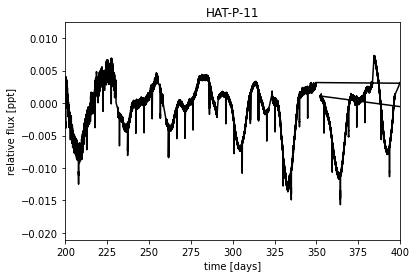

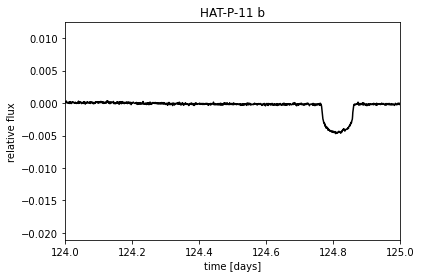

In [8]:
plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.xlim([200, 400])
plt.title("HAT-P-11")
plt.show()

plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim([124, 125])  # transit is here
# plt.ylim([-30e-3, -5e-3])
plt.title("HAT-P-11 b")
plt.show()

## Cleaning the data:

In [9]:
clean_mask = (all_lc.time.value >= 201) & (all_lc.time.value <=231) & (all_lc.time.value >= 847) & (all_lc.time.value <=905) & (all_lc.time.value >= 1337) & (all_lc.time.value <=1372) 

(300.0, 400.0)

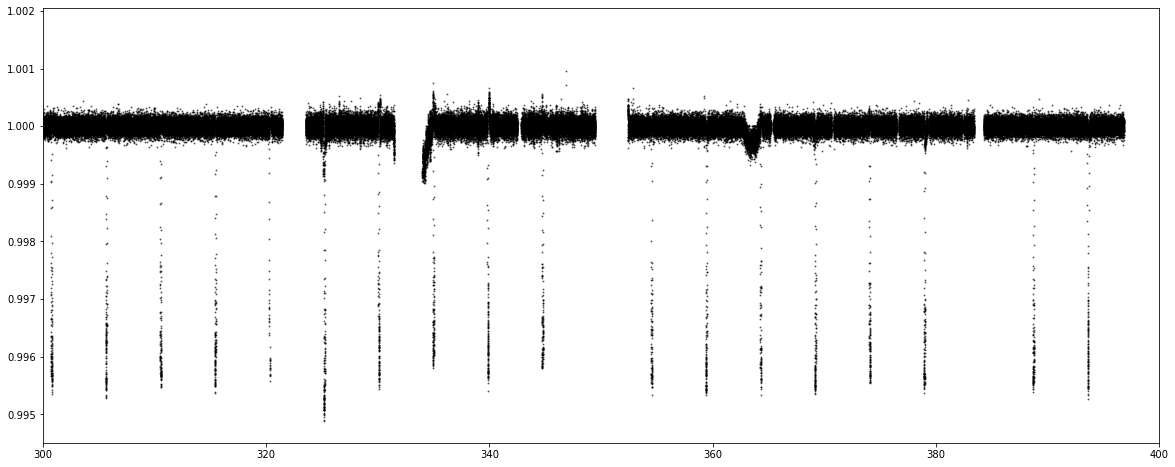

In [10]:
all_lc = all_lc[~clean_mask]
all_lc.flux.value[88000:129000] = np.nan
all_lc.flux.value[615000:690000] = np.nan
all_lc = all_lc.remove_nans()
clean_mask1 = (all_lc.time.value>1319) & (all_lc.time.value<1325)
all_lc = all_lc[~clean_mask1]
clean_mask2 = (all_lc.time.value>1347) & (all_lc.time.value<1353)
all_lc = all_lc[~clean_mask2]
clean_mask3 = (all_lc.time.value>331.5) & (all_lc.time.value<334)
all_lc = all_lc[~clean_mask3]
clean_mask4 = (all_lc.time.value>860) & (all_lc.time.value<880)
all_lc = all_lc[~clean_mask4]
tranmask = all_lc.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value,all_lc.flatten(mask=tranmask).flux, "k.", ms=2, alpha=0.5)
plt.xlim(300,400)

In [11]:
all_lc['time'].format = 'iso'

In [12]:
mask3 = [i.split('-')[0]=='2010' and i.split('-')[1]=='04' and i.split('-')[2].split(' ')[0]=='18' for i in all_lc['time'].value]
mask1 = [i.split('-')[0]=='2009' and i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='02' for i in all_lc['time'].value]
mask2 = [i.split('-')[0]=='2009' and i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='31' for i in all_lc['time'].value]
mask4 = [i.split('-')[0]=='2012' and i.split('-')[1]=='01' and i.split('-')[2].split(' ')[0]=='08' for i in all_lc['time'].value]

In [13]:
all_lc['time'].format = 'bkjd'

In [14]:
lc1 = all_lc[mask1]
lc2 = all_lc[mask2]
lc3 = all_lc[mask3]
lc4 = all_lc[mask4]

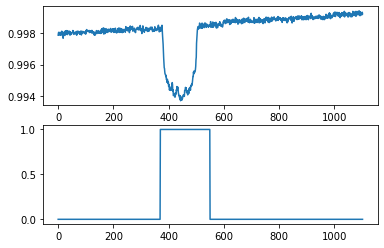

In [15]:
mask3 = np.zeros(len(lc3.flux), dtype=bool)
mask3[370:550] = 1
fig, ax = plt.subplots(2)
ax[0].plot(lc3.flux)
ax[1].plot(mask3)

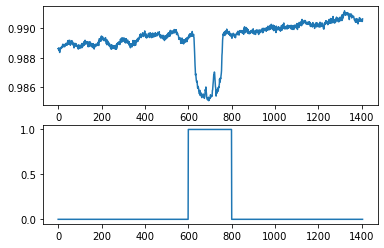

In [16]:
mask1 = np.zeros(len(lc1.flux), dtype=bool)
mask1[600:800] = 1
fig, ax = plt.subplots(2)
ax[0].plot(lc1.flux)
ax[1].plot(mask1)

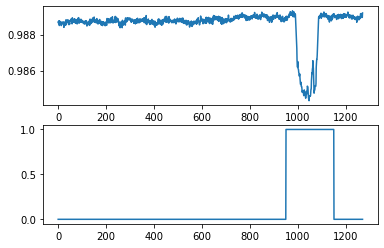

In [17]:
mask2 = np.zeros(len(lc2.flux), dtype=bool)
mask2[950:1150] = 1
fig, ax = plt.subplots(2)
ax[0].plot(lc2.flux)
ax[1].plot(mask2)

The $\texttt{starry}$ parameters:

In [18]:
star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0)
trueu1 = 0.646
trueu2 = 0.048
star.map[1] = trueu1
star.map[2] = trueu2

In [19]:
# These are the parameters we're going to try to infer
truerp = 0.039974684
trueperiod = planet_period
truet0 = planet_t0.value

planet_b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, amp=0.0),
    m=7.0257708e-5,  # mass in solar masses
    r=truerp,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=trueperiod,  # orbital period in days
    prot=1,
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    t0=truet0,
)

Pre-computing some matrices... Done.


Let's try the simultanious transit and GP model

In [20]:
def transit_gp(lightcurve,lcmask,start=None):
    starry.config.lazy = True
    
    x = np.ascontiguousarray(lightcurve.time.value, dtype=np.float64)
    y = np.ascontiguousarray(lightcurve.flatten(mask=lcmask).flux, dtype=np.float64)
    yerr = np.ascontiguousarray(lightcurve.flux_err, dtype=np.float64)
    mu = np.mean(y)
    y = (y / mu - 1) * 1e3
    yerr = yerr * 1e3 / mu

    plt.figure(figsize=(12,5))
    plt.plot(x, y, "k")
    # plt.xlim(x.min(), x.max())
    plt.xlabel("time [days]")
    plt.ylabel("relative flux [ppt]")
    _ = plt.title("HAT-P-11")

    with pm.Model() as model:
        # Shared parameters
        mean = pm.Normal("mean", mu=0, sd=10, testval=0)

        # the Star and Planet parameters
        # porb = pm.Uniform("porb", lower=4,upper=5, testval=4.888)
        # t0 = pm.Uniform("t0", lower=124,upper=125, testval=124.85) 
        # Orbital parameters for the planet.  Use mean values from Holczer+16.
        t0 = pm.Normal("t0", mu=124.85, sd=0.02, testval=124.85)
        porb = pm.Normal("period", mu=4.888, sd=0.01, testval=4.888)
        u1 = pm.Uniform("u1", lower=0.638,upper=0.7)
        u2 = pm.Uniform("u2", lower=0.033,upper=0.05) 
        rp = pm.Uniform("rp", lower=0.03232321,upper=0.04632)

        # Instantiate the star; all its parameters are assumed
        # to be known exactly, ecept for the limb-darkening coefficients
        A = starry.Primary(
            starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0
        )
        A.map[1] = u1
        A.map[2] = u2

        # Instantiate the planet. Everything is fixed except for
        # its luminosity and the hot spot offset.
        b = starry.Secondary(
            starry.Map(ydeg=1, udeg=0, amp=0, obl=0.0),
            m=7.0257708e-5,  # mass in solar masses
            r=rp,  # radius in solar radii
            inc=88.99, # orbital inclination
            porb=porb,  # orbital period in days
            prot=1,
            w=-162.149,  # Argument of periastron (little omega)
            ecc=0.265,  # eccentricity
            Omega=106,
            t0=t0,
        )

        # Instantiate the system as before
        sys = starry.System(A, b)

        # Our model for the flux
        flux_model = pm.Deterministic("flux_model", sys.flux(x))

        # Use the GP model from the stellar variability tutorial at
        # https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sd=2)

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5)
        )
        # Rotation period is ~36 days 
        log_prot = pm.Normal("log_prot", mu=np.log(36.53))
        prot = pm.Deterministic("prot", tt.exp(log_prot))
        log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
        log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
        f = pm.Uniform("f", lower=0.01, upper=1)

        # Set up the Gaussian Process model. See
        # https://celerite2.readthedocs.io/en/latest/tutorials/first/ for an
        # introduction. Here, we have a quasiperiodic term:
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=prot,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=x,
            diag=yerr**2 + tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )


        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("transit_obs", observed=y - flux_model)

        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("gp_pred", gp.predict(y - flux_model))


        # Optimize the MAP solution.
        if start is None:
            start = model.test_point

        map_soln = start

        map_soln = pmx.optimize(
            start=map_soln, vars=[sigma_rot, f, prot, log_Q0, log_dQ]
        )
        map_soln = pmx.optimize(
            start=map_soln,
            vars=[
                t0,
                porb,
                mean,
                u1,
                u2,
                rp,
            ],
        )
        map_soln = pmx.optimize(start=map_soln)
    return model, map_soln

Pre-computing some matrices... Done.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no si

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
message: Opt

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
message: Opt

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
message: Des

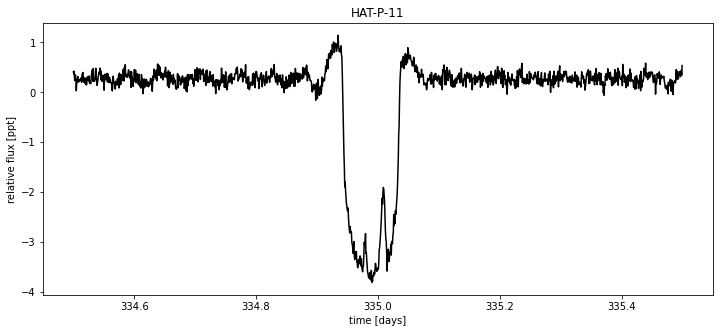

In [21]:
model1, map_soln1 = transit_gp(lc1,mask1)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0


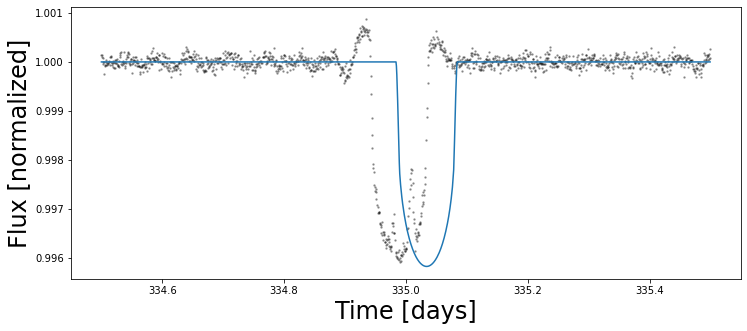

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(lc1.time.value, lc1.flatten(mask=mask1).flux, "k.", alpha=0.3, ms=3)
plt.plot(lc1.time.value, pmx.eval_in_model(model1.flux_model, model=model1))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [23]:
print('rp', map_soln1["rp"])
print('u1', map_soln1["u1"])
print('u2', map_soln1["u2"])
print('period', map_soln1['period'])
print('t0', map_soln1['t0'])

rp 0.03931445664455007
u1 0.6690024536004804
u2 0.041500153300653375
period 4.895021643374552
t0 124.85065332063878


In [24]:
def starry_system(u1,u2,rp,porb,tzero):
    star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0)
    star.map[1] = u1
    star.map[2] = u2

    planet_b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=0),
        m=7.0257708e-5,  # mass in solar masses
        r=rp,  # radius in solar radii
        inc=88.99, # orbital inclination
        porb=porb,  # orbital period in days
        prot=1,
        w=-162.149,  # Argument of periastron (little omega)
        ecc=0.265,  # eccentricity
        Omega=106, # I think it's lambda in Morris 2017
        t0=tzero,
    )
    return starry.System(star,planet_b)


In [25]:
starry.config.lazy = False
starry.config.quiet = True
A = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0)
A.map[1] = map_soln1['u1']
A.map[2] = map_soln1['u2']

b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0,amp=0),
    m=7.0257708e-5,  # mass in solar masses
    r=map_soln1['rp'],  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=map_soln1['period'],  # orbital period in days
    prot=1,
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    t0=map_soln1['t0'],
)

In [26]:
lc1.time.value

array([334.50024832, 334.5009294 , 334.50161047, ..., 335.49804959,
       335.49873077, 335.49941184])

In [27]:
lc1.fold(period=map_soln1['period'], epoch_time=map_soln1['t0'], normalize_phase=True).time.value

array([-0.17085433, -0.1707152 , -0.17057606, ...,  0.03298568,
        0.03312483,  0.03326397])

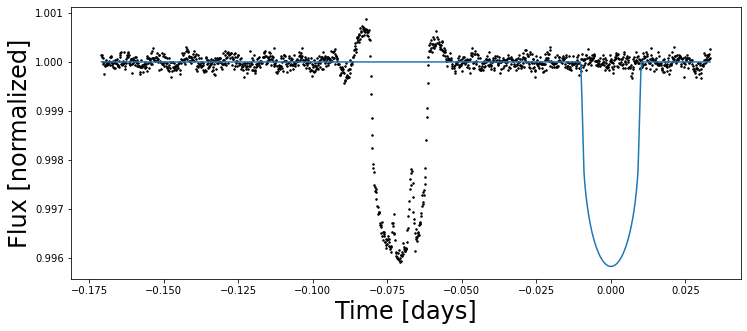

In [28]:
# sys = starry_system(map_soln1['u1'],map_soln1['u2'],map_soln1['rp'],map_soln1['porb'],map_soln1['t0'])
sys = starry.System(A, b)
# flux_true = sys.flux(lc1.time.value)
plt.figure(figsize=(12, 5))
plt.plot(lc1.fold(period=map_soln1['period'], epoch_time=map_soln1['t0'], normalize_phase=True).time.value, lc1.flatten(mask=mask1).flux, "k.", ms=3)
plt.plot(lc1.fold(period=map_soln1['period'], epoch_time=map_soln1['t0'], normalize_phase=True).time.value, sys.flux(lc1.time.value))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [29]:
map_soln1['flux_model'].min()

0.9958287725197482